In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from scipy.stats import norm, probplot
import xgboost as xgb

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import PolynomialFeatures,MaxAbsScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer 

from sklearn.model_selection import cross_val_score, train_test_split as split

from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomTreesEmbedding

from sklearn.metrics import roc_curve, mean_absolute_error, make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Exploration and Preprocessing

In [2]:
data = pd.read_csv('./input/airbnbs.csv')

In [3]:
data.head(3)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,70820,https://www.airbnb.com/rooms/70820,20231225202604,2023-12-25,city scrape,Townhouse in Bristol · ★4.77 · 1 bedroom · 1 b...,NaN,The neighbourhood is friendly and welcoming; m...,https://a0.muscache.com/pictures/b33c30be-56a0...,360195,...,4.94,4.76,4.76,NaN,f,5,0,5,0,1.52
1,117122,https://www.airbnb.com/rooms/117122,20231225202604,2023-12-25,city scrape,Condo in Bristol · ★4.96 · 1 bedroom · 1 bed ·...,NaN,This area is on the water and has splendid vie...,https://a0.muscache.com/pictures/13b41142-0946...,591555,...,4.99,4.97,4.88,NaN,f,1,0,1,0,1.18
2,176306,https://www.airbnb.com/rooms/176306,20231225202604,2023-12-25,city scrape,Townhouse in Bristol · ★4.79 · 1 bedroom · 1 b...,NaN,"Southville is pretty darn hip, frankly. North ...",https://a0.muscache.com/pictures/e1e7fdfc-9db5...,708175,...,4.94,4.78,4.74,NaN,f,1,0,1,0,0.39


In [4]:
data.shape

(2556, 75)

In [1]:
data = data.dropna(axis=1, how='all')

unique_counts = data.nunique()

data = data.loc[:, unique_counts > 1]

NameError: name 'data' is not defined

In [7]:
data.shape

(2556, 67)

In [8]:
# delect the rows without price
data = data.dropna(subset=['price'])

The data we have consists of floats, integers, booleans and strings (some of which should be boolean, some should be floats, some should be handled as single entities). Also, for some features we have NANs that will have to be filled using tranfromers.

In [9]:
# 要删除的列名列表
columns_to_drop = ['id', 'listing_url', 'last_scraped', 'source', 
                   'picture_url', 'host_id', 'host_url', 'host_location', 
                   'host_about', 'host_thumbnail_url', 'host_picture_url',
                   'neighbourhood','host_name']

# 仅删除存在的列
existing_columns_to_drop = [col for col in columns_to_drop if col in data.columns]

# 删除列
data = data.drop(existing_columns_to_drop, axis=1)


In [10]:
column_names = data.columns
print(column_names)

Index(['name', 'neighborhood_overview', 'host_since', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review

In [11]:
# see what variables are in the data
pd.set_option('display.max_colwidth', 0)
data[[ 'host_since',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'beds', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'first_review', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month']].agg(['unique']).transpose()


,unique
host_since,"[2011-01-24, 2011-05-15, 2011-06-16, 2012-01-08, 2012-03-18, 2012-03-17, 2012-03-29, 2012-04-08, 2012-04-09, 2012-06-24, 2012-10-28, 2013-03-30, 2013-05-14, 2013-05-18, 2013-05-19, 2013-06-27, 2013-07-03, 2013-01-03, 2013-09-04, 2013-10-17, 2013-04-13, 2014-01-18, 2014-02-23, 2014-04-02, 2013-07-19, 2014-06-29, 2014-06-30, 2011-06-01, 2014-07-18, 2014-07-31, 2014-08-18, 2014-08-27, 2012-11-14, 2014-09-11, 2014-10-02, 2013-07-20, 2013-09-03, 2014-11-10, 2013-02-15, 2014-12-12, 2015-02-05, 2014-08-03, 2015-02-23, 2015-01-05, 2013-12-01, 2015-03-20, 2015-01-09, 2014-09-13, 2013-05-12, 2015-02-10, 2014-03-30, 2014-07-14, 2014-09-10, 2015-03-24, 2014-02-17, 2015-07-04, 2015-06-30, 2014-04-17, 2015-07-18, 2014-05-24, 2015-06-11, 2013-02-12, 2015-08-06, 2015-08-09, 2015-07-05, 2015-07-30, 2014-02-02, 2015-08-13, 2015-07-24, 2013-08-01, 2015-09-25, 2015-10-07, 2015-10-12, 2015-10-18, 2015-09-28, 2013-10-29, 2015-05-08, 2015-09-05, 2013-07-17, 2015-11-10, 2015-11-11, 2015-02-18, 2015-06-03, 2017-05-14, 2014-07-25, 2014-06-20, 2016-01-03, 2013-07-31, 2014-09-01, 2013-11-23, 2015-06-09, 2016-02-24, 2016-02-27, 2016-03-04, 2016-01-05, 2015-03-13, 2013-12-17, 2016-03-16, 2015-11-03, 2016-04-02, ...]"
host_response_time,"[within an hour, within a few hours, nan, within a day, a few days or more]"
host_response_rate,"[100%, nan, 90%, 70%, 40%, 91%, 83%, 67%, 0%, 80%, 92%, 86%, 50%, 97%, 30%, 98%, 20%, 94%, 57%, 96%, 60%, 89%, 75%, 95%, 88%, 74%, 10%, 71%, 82%, 99%, 11%, 65%, 78%, 68%]"
host_acceptance_rate,"[94%, 87%, 57%, 100%, 93%, 77%, 81%, 73%, 98%, 97%, 88%, 80%, 75%, 83%, 0%, 59%, 89%, 70%, 72%, nan, 63%, 91%, 60%, 66%, 96%, 58%, 71%, 99%, 20%, 95%, 50%, 56%, 74%, 86%, 10%, 84%, 90%, 53%, 79%, 40%, 44%, 78%, 92%, 82%, 29%, 25%, 46%, 85%, 67%, 13%, 33%, 37%, 52%, 55%, 62%, 49%, 69%, 43%, 19%, 21%, 76%, 61%, 64%, 48%, 65%, 68%, 18%, 47%, 26%, 31%, 32%, 38%, 16%, 42%, 41%, 35%, 39%, 11%, 54%, 36%, 30%, 51%, 22%, 14%, 17%, 8%, 34%, 27%]"
host_is_superhost,"[f, t, nan]"
host_neighbourhood,"[nan, Hampstead, Shoreditch, Tooting Bec, Forest Hill, Flean More, Bow, Quaid Block, Pimlico, Crone Upper, LB of Waltham Forest, South of Nevsky, Mechanicsville, Dublin Docklands, Crec'heur, Northeast Washington, Brent Cross, North Maida Vale, Lekki Penninsula II, South Kensington, Temple Bar]"
host_listings_count,"[5, 2, 3, 1, 4, 7, 6, 194, 19, 55, 22, 70, 11, 9, 37, 8, 65, 1382, 10, 231, 160, 14, 357, 46, 2442, 27, 41, 36, 56, 26, 20, 48, 16, 77, 13, 125, 45, 1299, 31, 39, 18, 12, 38, 17]"
host_total_listings_count,"[7, 2, 3, 1, 4, 6, 5, 10, 8, 428, 27, 9, 69, 31, 115, 11, 34, 16, 15, 40, 13, 52, 44, 209, 5280, 12, 24, 451, 217, 14, 660, 37, 47, 22, 5529, 28, 48, 36, 63, 41, 160, 17, 89, 20, 139, 82, 1744, 91, 39, 42, 21, 18, 43]"
host_verifications,"[['email', 'phone', 'work_email'], ['email', 'phone'], ['phone'], ['phone', 'work_email'], []]"
host_has_profile_pic,"[t, f]"


In [12]:
# choose what we need

data_need = data[['neighbourhood_cleansed','host_is_superhost', 'property_type', 'room_type', 'bathrooms_text', 'beds', 'minimum_nights',
'number_of_reviews', 'number_of_reviews_ltm', 'last_review', 'first_review',
'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
'review_scores_value', 'instant_bookable', 'reviews_per_month', 'calculated_host_listings_count',
'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
'calculated_host_listings_count_shared_rooms','accommodates', 'price']]

In [13]:

def extract_info(name):
    # 提取评分
    rating = re.search(r'★(\d\.\d+)', name)
    rating = rating.group(1) if rating else None  # 提取数字部分

    # 提取卧室数量
    bedroom = re.search(r'(\d+) bedrooms?', name)
    bedroom = bedroom.group(1) if bedroom else None  # 提取数字部分

    return pd.Series([rating, bedroom])

# 假设你的 DataFrame 名为 data
data_need = data_need.copy()
# 确保操作是在原始 DataFrame 上进行
data_need[['rating', 'bedroom']] = data['name'].apply(extract_info)

data_need.head(3)

,neighbourhood_cleansed,host_is_superhost,property_type,room_type,bathrooms_text,beds,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,...,instant_bookable,reviews_per_month,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,accommodates,price,rating,bedroom
0,Windmill Hill,f,Private room in townhouse,Private room,1 shared bath,1.0,3,189,11,2023-11-29,...,f,1.52,5,0,5,0,2,$44.00,4.77,1
1,Hotwells & Harbourside,t,Private room in condo,Private room,2.5 shared baths,1.0,1,180,9,2023-11-26,...,f,1.18,1,0,1,0,2,$111.00,4.96,1
2,Southville,t,Private room in townhouse,Private room,1 shared bath,1.0,5,53,10,2023-12-12,...,f,0.39,1,0,1,0,2,$35.00,4.79,1


For property type we have 35 property types. To reduce number of features, property type is grouped in to 5 catagories: Apartment, House, Hotel1, Hotel2 and other, to use with OneHotEncoder
(Note: encodging and PCA yealded worse results then "manual" grouping)

# Finding missing values

In [14]:
data_need['property_type'].value_counts()

Entire rental unit                    656
Entire home                           398
Private room in home                  363
Entire condo                          209
Entire serviced apartment             105
Private room in townhouse             80 
Private room in rental unit           74 
Private room in condo                 59 
Entire townhouse                      50 
Private room in bed and breakfast     38 
Tiny home                             15 
Entire guest suite                    13 
Entire guesthouse                     12 
Entire cottage                        9  
Private room                          8  
Room in serviced apartment            8  
Entire loft                           8  
Camper/RV                             8  
Entire villa                          7  
Private room in tiny home             5  
Entire place                          4  
Entire cabin                          4  
Room in boutique hotel                3  
Room in hotel                     

In [15]:
dict1 = {'Entire Home': ['Entire home', 'Entire townhouse', 'Entire guesthouse', 'Entire cottage', 
                    'Entire villa', 'Entire vacation home', 'Entire bungalow', 'Entire cabin', 
                    'Entire loft'],
        'Entire Apartment': ['Entire rental unit', 'Entire condo', 'Entire serviced apartment', 
                         'Entire guest suite'],
    'Private Room': ['Private room in home', 'Private room in rental unit', 'Private room in townhouse', 
                     'Private room in condo', 'Private room in bed and breakfast', 'Private room', 
                     'Private room in guest suite', 'Private room in tiny home', 'Private room in guesthouse', 
                     'Private room in loft', 'Private room in serviced apartment', 'Private room in hostel', 
                     'Private room in camper/rv', 'Private room in cabin', 'Private room in yurt', 
                     'Private room in hut', 'Private room in castle', 'Private room in casa particular', 
                     'Private room in bungalow'],
    'Shared Room': ['Shared room in rental unit', 'Shared room in home'],
    'Hotel Room': ['Room in serviced apartment', 'Room in hotel', 'Room in boutique hotel', 
                   'Room in aparthotel'],
    'Other': ['Tiny home', 'Camper/RV', 'Treehouse', 'Barn', 'Houseboat', 'Religious building']
        }

# 反转映射
dict2 = {i: k for k, v in dict1.items() for i in v}

# 替换并计算
data_need['property_type_group'] = data_need['property_type'].replace(dict2)
print(data_need['property_type_group'].value_counts())

Entire Apartment    983
Private Room        644
Entire Home         490
Other               29 
Hotel Room          16 
Entire place        4  
Shared Room         3  
Name: property_type_group, dtype: int64


In [16]:
# split bathroom_text

def extract_bath_info(bathrooms_text):
    if pd.isna(bathrooms_text):
        return pd.Series([0, 0])
    
    # 提取浴室数量
    bath_count = 0
    shared_bath_count = 0
    
    # 提取半浴室情况
    if 'half' in bathrooms_text.lower():
        return pd.Series([shared_bath_count, bath_count])
    
    # 提取浴室数量和类型
    match = re.match(r'(\d*\.?\d*)\s?(shared|private)?\s?bath(s)?', bathrooms_text.lower())
    if match:
        bath_count = float(match.group(1)) if match.group(1) else 0
        if match.group(2) == 'shared':
            shared_bath_count = bath_count
            bath_count = 0

    return pd.Series([shared_bath_count, bath_count])

data_need[['shared_bath_count', 'bath_count']] = data_need['bathrooms_text'].apply(extract_bath_info)

print(data_need[['bathrooms_text', 'shared_bath_count', 'bath_count']])


        bathrooms_text  shared_bath_count  bath_count
0     1 shared bath     1.0                0.0       
1     2.5 shared baths  2.5                0.0       
2     1 shared bath     1.0                0.0       
3     1.5 shared baths  1.5                0.0       
4     1 shared bath     1.0                0.0       
...             ...     ...                ...       
2551  2 baths           0.0                2.0       
2552  1 bath            0.0                1.0       
2553  1 bath            0.0                1.0       
2554  2 baths           0.0                2.0       
2555  1 bath            0.0                1.0       

[2169 rows x 3 columns]


In [17]:
data_need['price'] = data_need['price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(float)

In [18]:
data_need.head(3)

,neighbourhood_cleansed,host_is_superhost,property_type,room_type,bathrooms_text,beds,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,accommodates,price,rating,bedroom,property_type_group,shared_bath_count,bath_count
0,Windmill Hill,f,Private room in townhouse,Private room,1 shared bath,1.0,3,189,11,2023-11-29,...,0,5,0,2,44.0,4.77,1,Private Room,1.0,0.0
1,Hotwells & Harbourside,t,Private room in condo,Private room,2.5 shared baths,1.0,1,180,9,2023-11-26,...,0,1,0,2,111.0,4.96,1,Private Room,2.5,0.0
2,Southville,t,Private room in townhouse,Private room,1 shared bath,1.0,5,53,10,2023-12-12,...,0,1,0,2,35.0,4.79,1,Private Room,1.0,0.0


In [19]:
data_need = data_need.drop(['property_type','bathrooms_text'], axis=1)

In [40]:
data_need.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2555
Data columns (total 30 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   neighbourhood_cleansed                        2167 non-null   object 
 1   host_is_superhost                             2165 non-null   object 
 2   room_type                                     2167 non-null   object 
 3   beds                                          2119 non-null   float64
 4   minimum_nights                                2167 non-null   int64  
 5   number_of_reviews                             2167 non-null   int64  
 6   number_of_reviews_ltm                         2167 non-null   int64  
 7   last_review                                   1887 non-null   object 
 8   first_review                                  1887 non-null   object 
 9   review_scores_rating                          1887 non-null   f

In [20]:
col_to_fillna_most_frequent = ['beds', 'bedroom', 'host_is_superhost']
col_to_fillna_mean = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                      'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                      'review_scores_value', 'reviews_per_month']
col_to_getdummies = ['property_type_group', 'room_type', 'instant_bookable']
col_no_change = ['accommodates', 'number_of_reviews', 'number_of_reviews_ltm', 'minimum_nights',
                 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
                 'shared_bath_count', 'bath_count']

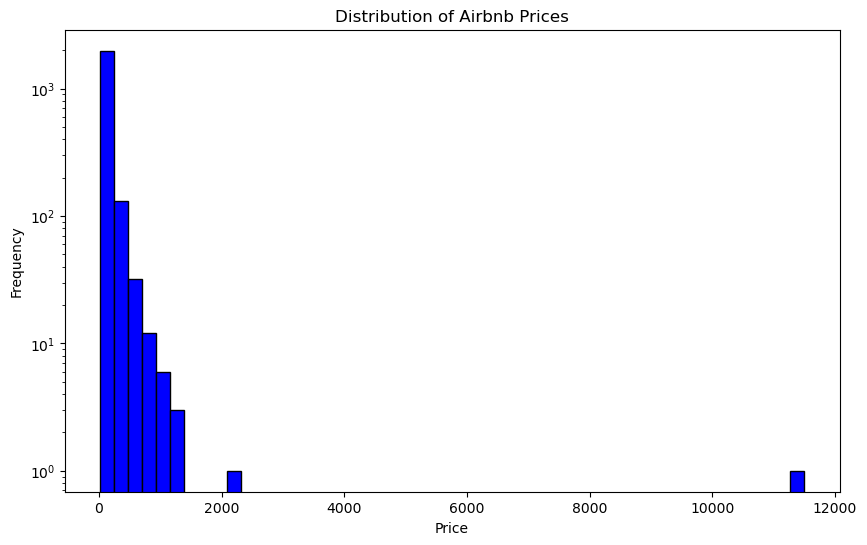

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(data_need['price'], bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Airbnb Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.yscale('log')  # Using a log scale for better visualization of the distribution
plt.show()

In [22]:
high_price_listings = data_need[data_need['price'] > 2000]
high_price_listings.head()

,neighbourhood_cleansed,host_is_superhost,room_type,beds,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,first_review,review_scores_rating,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,accommodates,price,rating,bedroom,property_type_group,shared_bath_count,bath_count
1562,Brislington East,f,Entire home/apt,15.0,2,5,5,2023-11-19,2023-07-03,5.0,...,1,0,0,16,2214.0,5.0,13,Entire Home,0.0,15.0
1783,Lockleaze,f,Entire home/apt,6.0,1,1,1,2023-02-05,2023-02-05,5.0,...,2,0,0,8,11499.0,None,3,Entire Home,0.0,1.0


In [27]:
data_need['price'].describe()

count    2167.000000
mean     127.510383 
std      123.448206 
min      15.000000  
25%      60.000000  
50%      98.000000  
75%      146.000000 
max      1286.000000
Name: price, dtype: float64

In [66]:
data_need.head(3)

,neighbourhood_cleansed,host_is_superhost,room_type,beds,minimum_nights,number_of_reviews,number_of_reviews_ltm,last_review,first_review,review_scores_rating,...,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,accommodates,price,rating,bedroom,property_type_group,shared_bath_count,bath_count,log_price
0,Windmill Hill,f,Private room,1.0,3,189,11,2023-11-29,2013-10-18,4.77,...,5,0,2,44.0,4.77,1,Private Room,1.0,0.0,3.806662
1,Hotwells & Harbourside,t,Private room,1.0,1,180,9,2023-11-26,2011-07-04,4.96,...,1,0,2,111.0,4.96,1,Private Room,2.5,0.0,4.718499
2,Southville,t,Private room,1.0,5,53,10,2023-12-12,2012-11-18,4.79,...,1,0,2,35.0,4.79,1,Private Room,1.0,0.0,3.583519


In [23]:
data_need = data_need.drop(data_need[data_need['price'] > 2000].index)

# explore data

Minimally skewed and showing insignificant kurtosis (<1) this passes the spot check for normal distribution (bell-shaped, symmetrical about the center). Likewise, our probability plot appears linear and reinforces our decision to leave log_price as-is.

In [38]:
data_need['log_price'] = np.log1p(data_need['price'])

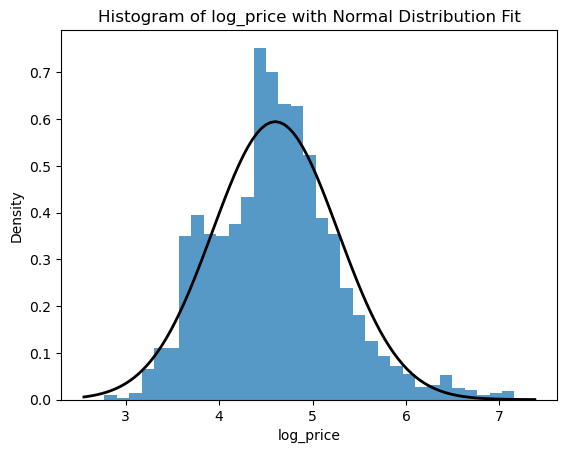

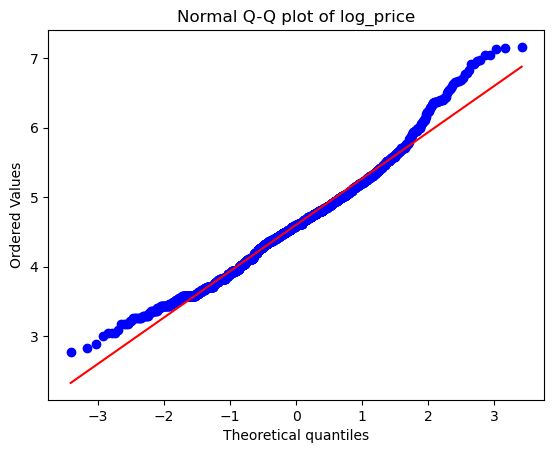

Skewness: 0.477380
Kurtosis: 0.648204


In [39]:
# 对 price 列应用对数变换
data_need['log_price'] = np.log1p(data_need['price'])

# 绘制直方图并拟合正态分布曲线
sns.histplot(data_need['log_price'], kde=False, stat="density", linewidth=0)
plt.xlabel('log_price')
plt.ylabel('Density')
plt.title('Histogram of log_price with Normal Distribution Fit')

# 在直方图上叠加正态分布曲线
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, data_need['log_price'].mean(), data_need['log_price'].std())
plt.plot(x, p, 'k', linewidth=2)

# 显示直方图
plt.show()

# 绘制正态概率图
fig = plt.figure()
res = probplot(data_need['log_price'], plot=plt)
plt.title('Normal Q-Q plot of log_price')
plt.show()

# 计算变换后的偏度和峰度
print("Skewness: %f" % data_need['log_price'].skew())
print("Kurtosis: %f" % data_need['log_price'].kurt())

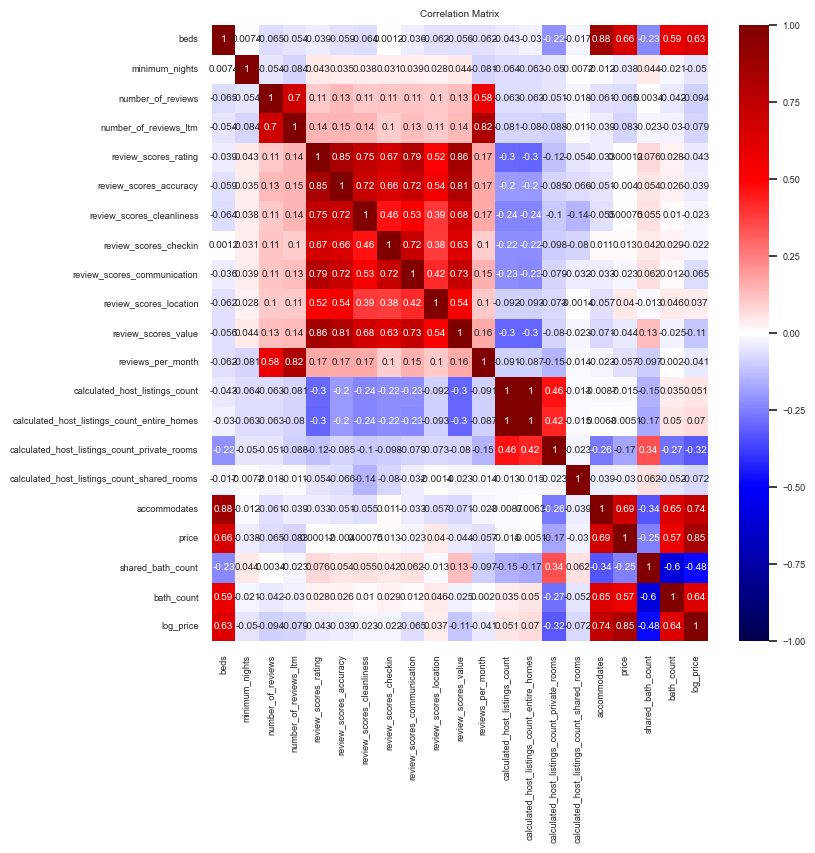

In [47]:
sns.set(font_scale=0.6)
plt.figure(figsize=(8, 8))

corrmat = data_need.corr(numeric_only=True)

sns.heatmap(corrmat, cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

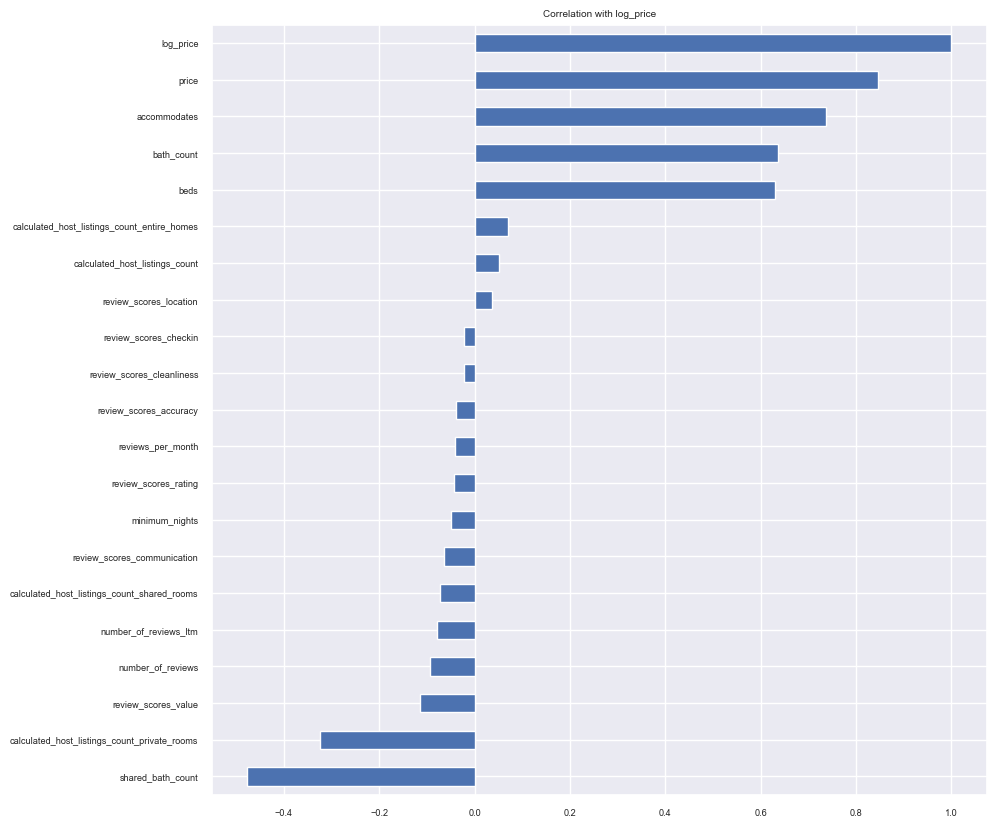

In [50]:
plt.figure(figsize=(10, 10))

corrmat = data_need.corr(numeric_only=True)

# 选择与 log_price 的相关性，排序并绘制水平条形图
corrmat["log_price"].sort_values().plot(kind="barh")
plt.title('Correlation with log_price')
plt.show()